In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt


In [2]:
import sys
sys.path.append("/home/kim2712/Desktop/research/conformal_tree/")
sys.path.append("/home/kim2712/Desktop/research/rlabc/")

In [3]:
from rlabc.treeproposal import CARTTree
CARTTree

rlabc.treeproposal.CARTTree

In [17]:
from conformal_tree._utils.tree_utils import tree_membership,tree_plotter
from conformal_tree._utils.conformal_utils import conf_plotter

from conformal_tree._data import sin_simul as data_gen
opt1=0
opt2=1
(x_train,y_train),(x_calib,y_calib),(x_test, y_test) = data_gen.get_data(n0=200,
                                                                         n=400,seed=1, 
                                                                         x_option=opt1,
                                                                         noise_option=opt2)

from conformal_tree._nets import network_toy as nt
reload(nt)

<module 'conformal_tree._nets.network_toy' from '/home/kim2712/Desktop/research/conformal_tree/conformal_tree/_nets/network_toy.py'>

In [18]:
import torch
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


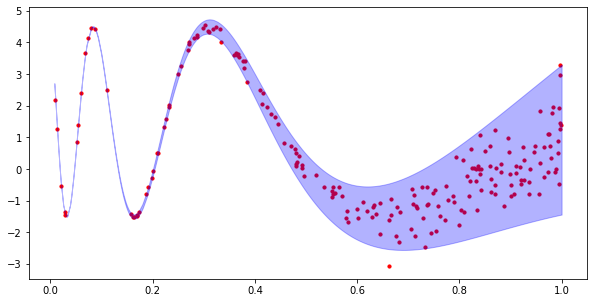

In [19]:
from scipy.stats import norm
q_upper = 0.9
y_true_low = data_gen.cond_exp(x_test, option=opt1) - norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test, option=opt2))
y_true_up =  data_gen.cond_exp(x_test, option=opt1) + norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test, option=opt2))
 
conf_plotter(x_test[:,0], y_true_low, y_true_up,test_data=(x_train[:,0],y_train)) 
#conf_plotter(x_test[:,0], y_true_low, y_true_up,test_data=(x_test[:,0],y_test)) 


In [20]:
# 0. I need a machine learning model
# 1. I need conformal method
# 2. I need a CART fitting method - but assume that I have
# 3. I need to code my algorithm

In [21]:
X_train, Y_train = torch.from_numpy(x_train).to(DEVICE).float(),torch.from_numpy(y_train).to(DEVICE)
X_calib, Y_calib = torch.from_numpy(x_calib).to(DEVICE).float(),torch.from_numpy(y_calib).to(DEVICE)

In [22]:
net = nt.MLP(input_dim=1, out_dim=1, device = DEVICE, factor=128)

In [23]:
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)#, weight_decay=0.999)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)

In [24]:
for it in range(10000):
    optimizer.zero_grad()
    
    Y_pred = net(X_train)
    loss = (Y_train.view(-1)-Y_pred.view(-1)).pow(2).mean()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if it % 1000 ==0: 
        print(loss)

tensor(3.4864, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.3240, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2543, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2512, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2492, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2481, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2477, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2474, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2473, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.2473, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


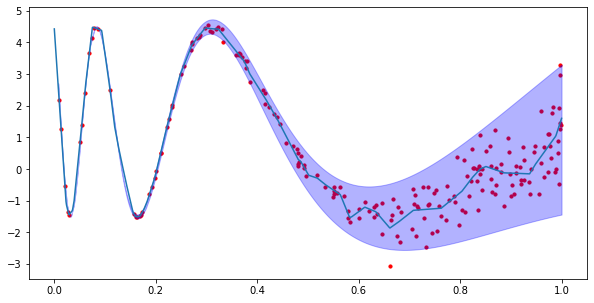

In [25]:
from scipy.stats import norm

y_true_low = data_gen.cond_exp(x_test,option=opt1) - norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
y_true_up =  data_gen.cond_exp(x_test,option=opt1) + norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
 
conf_plotter(x_test[:,0], y_true_low, y_true_up,
             test_data=(x_train[:,0],y_train), model=net) 

<BarContainer object of 200 artists>

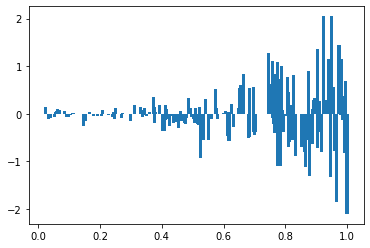

In [26]:
## Error calculation
with torch.no_grad():
    out_calib = net(X_calib).cpu().view(-1)
error = (Y_calib.cpu().view(-1) - out_calib.view(-1)).numpy()
plt.bar(x_calib[:,0],error, width=0.01)



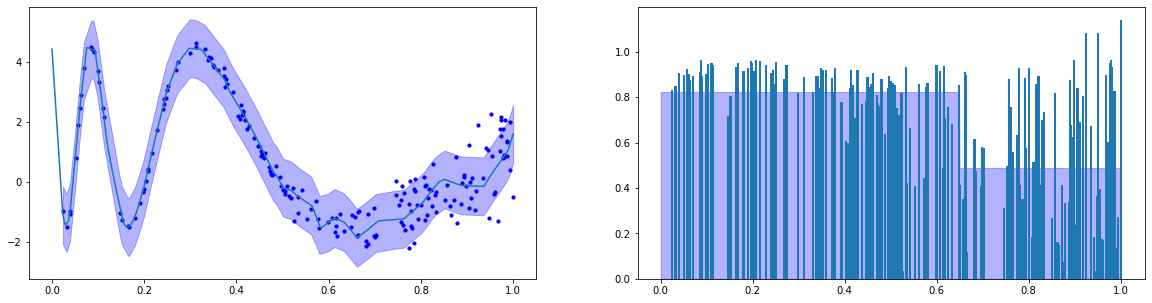

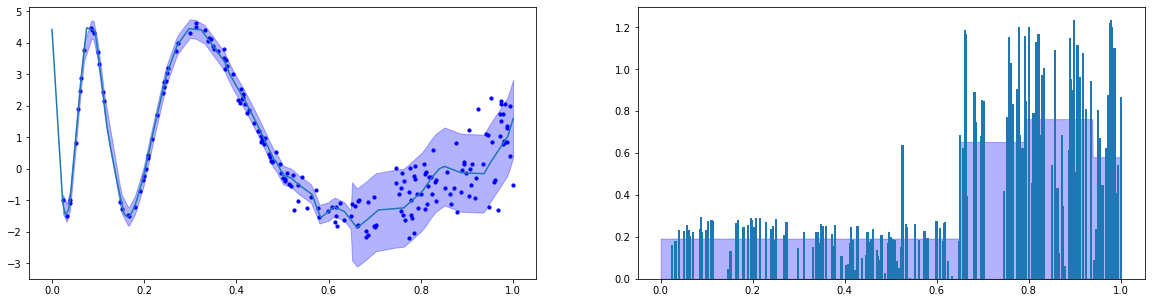

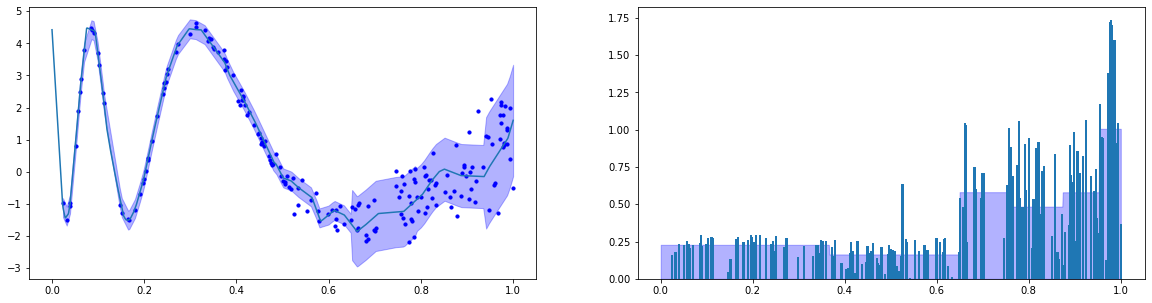

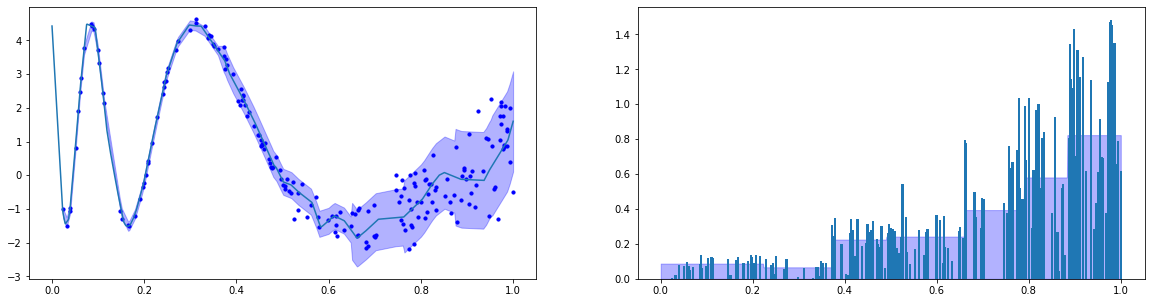

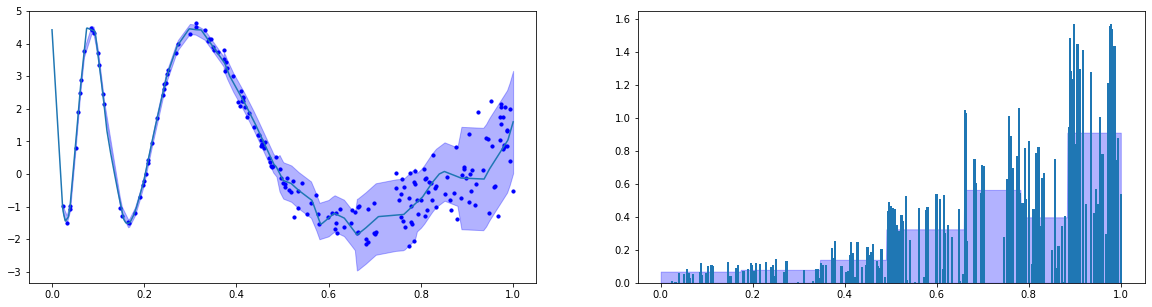

In [34]:
tree_model, membership = tree_membership(x_calib, x_calib[:,0]*0)
bin_idx = np.unique(membership)

for it in range(5):
    fig, axis = plt.subplots(1, 2, figsize=(20,5))
    
    y_low, y_up = out_calib,out_calib
    
    idx_counter = 0
    indices = 0*y_low
    
    for idx in bin_idx:
        
        idx_counter +=1
        indices[membership==idx] = idx_counter
        
        x_subset = x_calib[membership==idx]
        error_subset = error[membership==idx]
        C = np.quantile(np.abs(error_subset), 0.90)
        y_low -= C* (membership==idx)
        y_up  += C* (membership==idx)


    #conf_plotter(x_calib[:,0],  y_low, y_up,test_data=(x_test,y_test),model=net, ax=axis[0]) #y_cal = y_calib
    conf_plotter(x_calib[:,0],  y_low, y_up,y_cal =y_calib,model=net, ax=axis[0]) #y_cal = y_calib
    
    

    c_gap = torch.minimum((y_low-y_calib).abs(), (y_up-y_calib).abs())
    tree_model, membership = tree_membership(x_calib, c_gap, max_depth=20,
                                             max_leaf_nodes=(it+1)*2,
                                             min_samples_leaf=20)
    bin_idx = np.unique(membership)
    
    tree_plotter(tree_model,x_calib[:,0], c_gap, ax=axis[1])
    plt.show()
    

[Text(128.34, 199.32, 'X[0] <= 0.398\nmse = 0.091\nsamples = 150\nvalue = 0.562'),
 Text(44.64, 163.07999999999998, 'X[0] <= 0.163\nmse = 0.083\nsamples = 41\nvalue = 0.408'),
 Text(22.32, 126.83999999999999, 'mse = 0.068\nsamples = 13\nvalue = 0.283'),
 Text(66.96000000000001, 126.83999999999999, 'X[0] <= 0.319\nmse = 0.079\nsamples = 28\nvalue = 0.465'),
 Text(44.64, 90.6, 'mse = 0.069\nsamples = 17\nvalue = 0.558'),
 Text(89.28, 90.6, 'mse = 0.06\nsamples = 11\nvalue = 0.322'),
 Text(212.04, 163.07999999999998, 'X[0] <= 0.722\nmse = 0.082\nsamples = 109\nvalue = 0.62'),
 Text(156.24, 126.83999999999999, 'X[0] <= 0.621\nmse = 0.026\nsamples = 50\nvalue = 0.795'),
 Text(133.92000000000002, 90.6, 'X[0] <= 0.484\nmse = 0.027\nsamples = 40\nvalue = 0.775'),
 Text(89.28, 54.359999999999985, 'X[0] <= 0.448\nmse = 0.025\nsamples = 20\nvalue = 0.807'),
 Text(66.96000000000001, 18.119999999999976, 'mse = 0.032\nsamples = 10\nvalue = 0.729'),
 Text(111.6, 18.119999999999976, 'mse = 0.006\nsamp

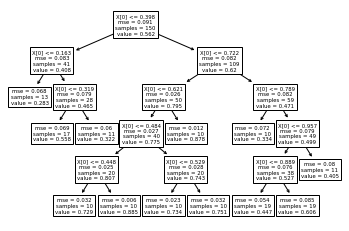

In [54]:
from sklearn import tree
tree.plot_tree(tree_model)

In [ ]:
th = tree_model.tree_.threshold
sel_idx = th>-1
th=th[sel_idx]
order = th.argsort()
threshold = th[order]
value = tree_model.tree_.value[sel_idx][order].reshape(-1)

In [52]:
tree_model.tree_.threshold

array([ 0.88870856,  0.37905248,  0.92653859,  0.16274972,  0.7608768 ,
       -2.        , -2.        , -2.        ,  0.24538746,  0.50439283,
        0.81893709, -2.        , -2.        , -2.        , -2.        ,
        0.44769429,  0.6124917 , -2.        , -2.        , -2.        ,
       -2.        ])

In [47]:
value,threshold

(array([0.46761225, 0.56587175, 0.32269735, 0.18924632, 0.21592574,
        0.24168519, 0.2529235 , 0.34079318, 0.38658791, 0.64215015]),
 array([0.16274972, 0.24538746, 0.37905248, 0.44769429, 0.50439283,
        0.6124917 , 0.7608768 , 0.81893709, 0.88870856, 0.92653859]))

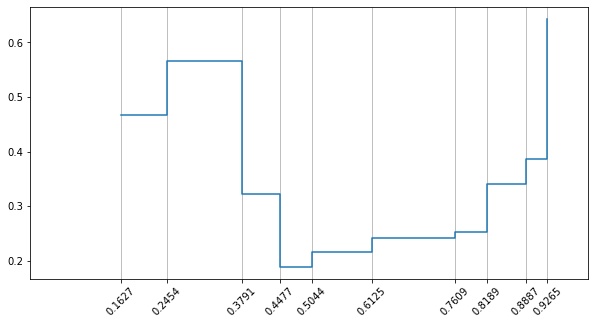

In [51]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.step(threshold, value, where='post')
plt.xticks(threshold, rotation=45)  # Rotate the ticks for better readability
plt.xlim(0, 1)

# Set the labels for the axes
#plt.xlabel('Threshold')
#plt.ylabel('Value')

# Add a grid for better readability
#plt.grid(True)
plt.gca().xaxis.grid(True)

# Show the plot
plt.show()

In [40]:
tree_model.tree_.threshold

array([ 0.88870856,  0.37905248,  0.92653859,  0.16274972,  0.7608768 ,
       -2.        , -2.        , -2.        ,  0.24538746,  0.50439283,
        0.81893709, -2.        , -2.        , -2.        , -2.        ,
        0.44769429,  0.6124917 , -2.        , -2.        , -2.        ,
       -2.        ])

In [39]:
tree_model.tree_.value

array([[[0.38658791]],

       [[0.32269735]],

       [[0.64215015]],

       [[0.46761225]],

       [[0.2529235 ]],

       [[0.82698267]],

       [[0.50080764]],

       [[0.27109325]],

       [[0.56587175]],

       [[0.21592574]],

       [[0.34079318]],

       [[0.42471904]],

       [[0.28084614]],

       [[0.62189776]],

       [[0.52478601]],

       [[0.18924632]],

       [[0.24168519]],

       [[0.32226154]],

       [[0.18480776]],

       [[0.26213604]],

       [[0.13457904]]])

In [36]:
tree_model.tree_.__dir__()

['__new__',
 '__reduce__',
 '__getstate__',
 '__setstate__',
 'predict',
 'apply',
 'decision_path',
 'compute_feature_importances',
 'compute_partial_dependence',
 'n_classes',
 'children_left',
 'children_right',
 'n_leaves',
 'feature',
 'threshold',
 'impurity',
 'n_node_samples',
 'weighted_n_node_samples',
 'value',
 'n_features',
 'n_outputs',
 'max_n_classes',
 'max_depth',
 'node_count',
 'capacity',
 '__doc__',
 '__pyx_vtable__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__init__',
 '__reduce_ex__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']